In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('train.csv')
stop = stopwords.words('english')

In [3]:
df['stop_words_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))
df['stop_words'] = df['text'].apply(lambda x: [w for w in str(x).lower().split() if w in stop])
df

,id,keyword,location,text,target,stop_words_count,stop_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,6,"[our, are, the, of, this, all]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,11,"[all, to, in, are, being, by, no, other, or, i..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,[in]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,7,"[just, this, from, as, from, into, a]"
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,2,"[a, into]"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,9,"[the, out, of, in, in, the, of, the, very]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,2,"[s, of]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,5,"[after, an, with, a, in]"


## distribucion de cantidad de stopwords por target

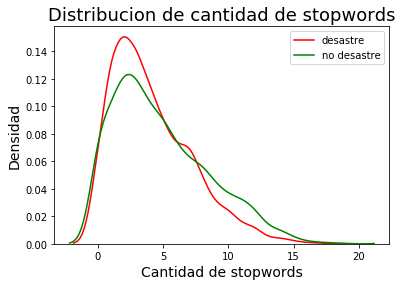

In [4]:
g = sns.distplot(df[df['target'] == 1]['stop_words_count'], color = 'red', label = 'desastre', hist=False)
g = sns.distplot(df[df['target'] == 0]['stop_words_count'], color = 'green', label = 'no desastre', hist=False)
g.set_title("Distribucion de cantidad de stopwords", fontsize=18)
g.set_ylabel("Densidad", fontsize=14)
g.set_xlabel("Cantidad de stopwords", fontsize=14)
g.get_figure().savefig('imgs/stopwords_count_distribution.png')

### se observan valores de densidad similares para ambos targets. Comparando con el grafico de densidad de cantidad de palabras, se podria decir q los stopwords representan la minoria de los tweets, vamos a analizarlo a continuacion:

In [5]:
df['words_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['stop_words_percentage'] = (df['stop_words_count'] / df['words_count']) * 100

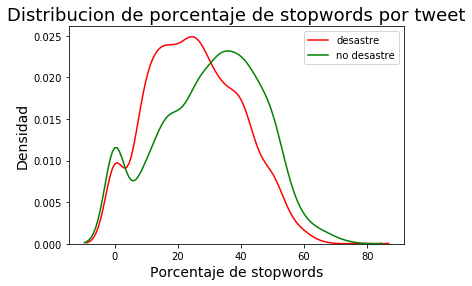

In [6]:
g = sns.distplot(df[df['target'] == 1]['stop_words_percentage'], color = 'red', label = 'desastre', hist=False)
g = sns.distplot(df[df['target'] == 0]['stop_words_percentage'], color = 'green', label = 'no desastre', hist=False)
g.set_title("Distribucion de porcentaje de stopwords por tweet", fontsize=18)
g.set_ylabel("Densidad", fontsize=14)
g.set_xlabel("Porcentaje de stopwords", fontsize=14)
g.get_figure().savefig('imgs/stopwords_percentage_distribution.png')

### en el grafico se pude apreciar una diferencia en los valores medio, el de not real disaster es mayor

## Top stopwords

In [7]:
df['stop_words'] = df['stop_words'].apply(lambda x: ' '.join(x))

In [8]:
stopwords_series = df['stop_words'].str.split(expand=True).stack().value_counts()

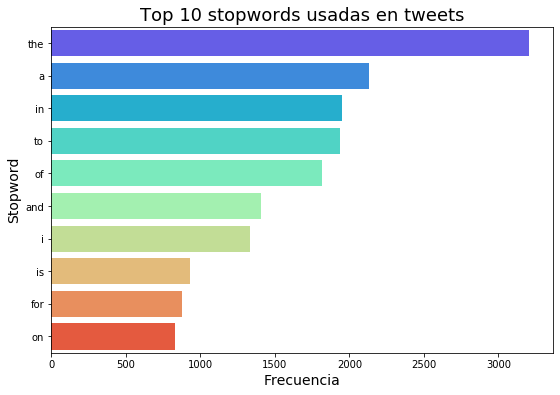

In [9]:
plt.figure(figsize=(9,6))
g = sns.barplot(x=stopwords_series[:10], y=stopwords_series[:10].index, palette='rainbow', orient='h')
g.set_xlabel('Frecuencia', fontsize=14)
g.set_ylabel('Stopword', fontsize=14)
g.set_title('Top 10 stopwords usadas en tweets', fontsize=18)
g.get_figure().savefig('imgs/top_stopwords.png')

### ahora voy a ver como se distribuyen las top 10 stopwords en cada target

In [13]:
stopwords_series_real = df[df['target'] == 1]['stop_words'].str.split(expand=True).stack().value_counts()
stopwords_series_not_real = df[df['target'] == 0]['stop_words'].str.split(expand=True).stack().value_counts()
df2 = stopwords_series_real.to_frame()
df2['not_real'] = stopwords_series_not_real
df2 = df2.reset_index()
df3 = df2[df2['index'].isin(list(stopwords_series[:10].index))]

In [14]:
df3 = df3.set_index(['index'], drop=True)
df3 = df3.rename(columns={'not_real': 'no desastre', 0: 'desastre'})

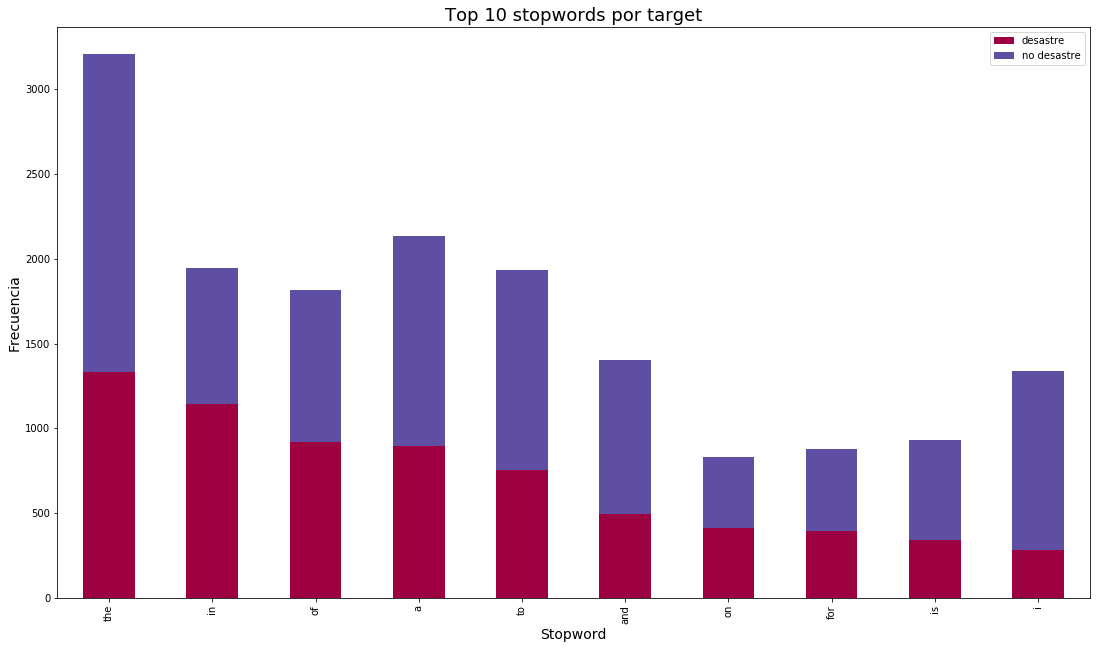

In [15]:
f = plt.figure()
plt.title('Top 10 stopwords por target', fontsize=18)
ax = df3.plot(kind='bar', stacked=True, colormap='Spectral', figsize=(18.5,10.5), ax=f.gca())
ax.set_ylabel('Frecuencia', fontsize=14);
ax.set_xlabel('Stopword', fontsize=14);
plt.show()
f.savefig('imgs/top_stopwords_targets.png')

### en el top 10 de stopwords se encuentran algunos valores interesantes, por ejemplo el caso de I (yo en castellano), su uso me dice q es probable q el tweet sea un not real disaster. Este resultado nos lleva a querer averiguar cuales son los 10 stopwords que se comportan como I (q sea muy utilizado para un target y muy poco para el otro, es decir los de mayor porcentage de diferencia)

In [16]:
df2['difference'] = abs(df2[0] - df2['not_real'])
df2['total'] = df2[0] + df2['not_real']
df2['percentage'] = (df2['difference'] / df2['total']) * 100

In [17]:
df4 = df2.nlargest(10, columns=['percentage'])
df4 = df4.rename(columns={'not_real': 'no desastre', 0: 'desastre'})
df4 = df4.set_index(['index'], drop=True)
df4 = df4.drop(labels=['difference', 'total', 'percentage'], axis=1)

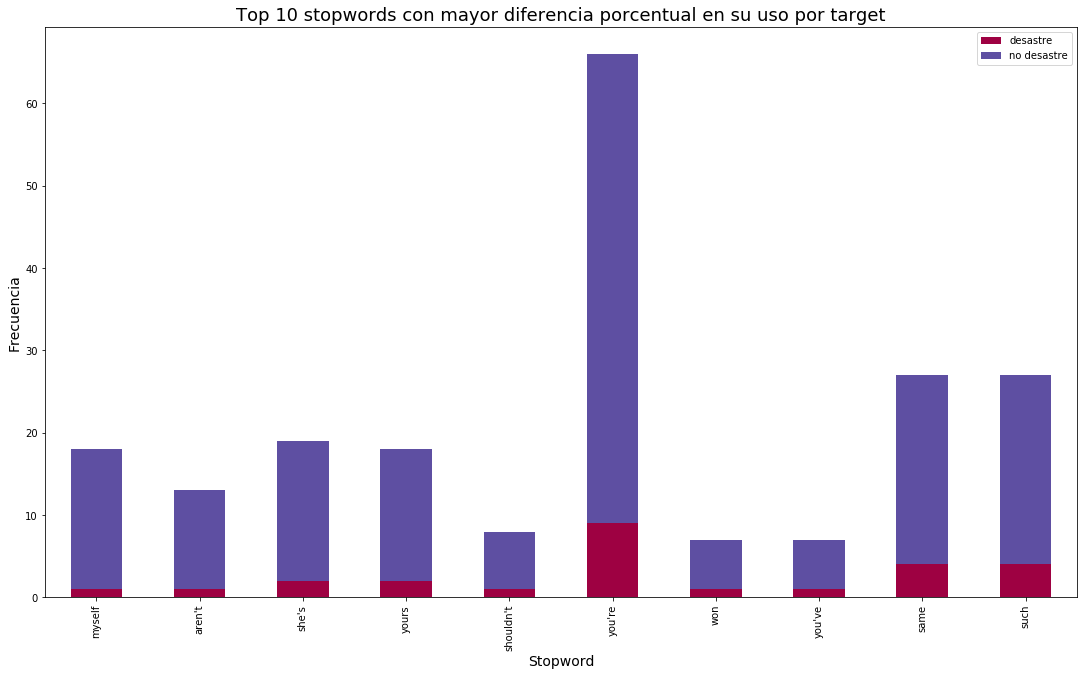

In [18]:
f = plt.figure()
plt.title('Top 10 stopwords con mayor diferencia porcentual en su uso por target', fontsize=18)
ax = df4.plot(kind='bar', stacked=True, colormap='Spectral', figsize=(18.5,10.5), ax=f.gca())
ax.set_ylabel('Frecuencia', fontsize=14);
ax.set_xlabel('Stopword', fontsize=14);
plt.show()
f.savefig('imgs/top_stopwords_freq_diff.png')

### se puede apreciar que la frecuencia de estas stopwords es chica (por ejemplo no aparece ninguna del top10) y que todas se usan mucho mas en tweets sobre not real disasters q sobre real disasters